Collect & Import all the libraries once before coding

In [180]:
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import random 
from sklearn.model_selection import train_test_split
import shutil


## EDA och filhantering 

- #### Läs in 10 bilder slumpmässigt, plotta dem och extrahera deras labels och skriv ut i titeln.


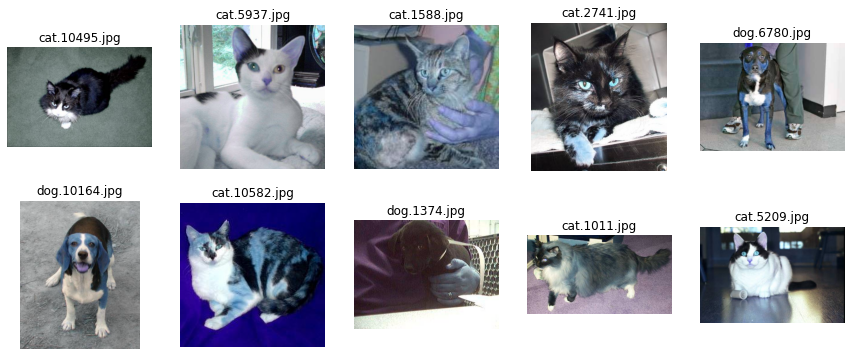

In [438]:
def plot_n_random_img(n, path):

    # Seclect sample images
    samples = random.sample(os.listdir(path), n)

    # loop the path for images
    path_images = [f"{path}/{file_name}" for file_name in samples]

    # read the images to array
    images_read = [cv2.imread(file) for file in path_images]

    # Display the images with labels
    fig, axes = plt.subplots(2, int(n/2), figsize=(15, 6))
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images_read[i])
        ax.set_title(f"{samples[i]}")
        ax.axis("off")
    

path = "../../Deep_learning/Lab/original_data/train/train"
plot_n_random_img(10, path)

- #### Skapa folderstrukturen nedan med Python:

** I only show how to create dir(train/test) by coding. 

Create the dir (train/test) for small data:

In [182]:
# experiment_small_data = "../../Deep_learning/Lab/experiment_small_data"

# # For small train

# small_train_dir = os.path.join(experiment_small_data, "train")
# os.mkdir(small_train_dir)

# # For small test

# small_test_dir = os.path.join(experiment_small_data, "test")
# os.mkdir(small_test_dir)

# # For small val 

# small_val_dir = os.path.join(experiment_small_data, "val")
# os.mkdir(small_val_dir)

Create the dir (train/test) for tiny data:

In [183]:
# experiment_tiny_data = "../../Deep_learning/Lab/experiment_tiny_data"

# # For tiny train

# tiny_train_dir = os.path.join(experiment_tiny_data, "train")
# os.mkdir(tiny_train_dir)

# # For tiny test

# tiny_test_dir = os.path.join(experiment_tiny_data, "test")
# os.mkdir(tiny_test_dir)

# # For tiny val 

# tiny_val_dir = os.path.join(experiment_tiny_data, "val")
# os.mkdir(tiny_val_dir)

- #### Nu ska göra train|val|test split med följande splits:

experiment_small:
- train - 1600 (800 dogs, 800 cats)
- val - 400 (200 dogs, 200 cats)
- test - 500 (250 dogs, 250 cats)

experiment_tiny (BONUS):
- train - 160 (80 dogs, 80 cats)
- val - 40 (20 dogs, 20 cats)
- test - 50 (25 dogs, 25 cats)



In [184]:
# Check how many train pics
train_img = os.listdir("../../Deep_learning/Lab/original_data/train/train")
len(train_img)

25000

Create a total name's pool for dogs and cats

In [236]:
train_cats = ["cat.{}.jpg".format(i) for i in random.sample(range(0, 12500), 12500)]
train_dogs = ["dog.{}.jpg".format(i) for i in random.sample(range(0, 12500), 12500)]

Original folder for img

In [240]:
original_dir = "../../Deep_learning/Lab/original_data/train/train"

Define a function for split

In [381]:
def train_val_test_split(n_train, n_val, n_test, path_train, path_val, path_test):

    # here randomly select n images from 1st-8000st, 8000st-10000st, 10000st-12500st for train, val and test. 

    train_cat = random.sample(train_cats[0:8000], int(n_train/2))
    train_dog = random.sample(train_dogs[0:8000], int(n_train/2))

    val_cat = random.sample(train_cats[8000:10000], int(n_val/2))
    val_dog = random.sample(train_dogs[8000:10000], int(n_val/2))

    test_cat = random.sample(train_cats[10000:12500], int(n_test/2))
    test_dog = random.sample(train_dogs[10000:12500], int(n_test/2))

    for cats, dogs in zip(train_cat, train_dog):
        src = os.path.join(original_dir, cats)
        dst = os.path.join(path_train, cats)
        shutil.copyfile(src, dst)
        src = os.path.join(original_dir, dogs)
        dst = os.path.join(path_train, dogs)
        shutil.copyfile(src, dst)
            
    for cats, dogs in zip(val_cat, val_dog):
        src = os.path.join(original_dir, cats)
        dst = os.path.join(path_val, cats)
        shutil.copyfile(src, dst)
        src = os.path.join(original_dir, dogs)
        dst = os.path.join(path_val, dogs)
        shutil.copyfile(src, dst)

    for cats, dogs in zip(test_cat, test_dog):
        src = os.path.join(original_dir, cats)
        dst = os.path.join(path_test, cats)
        shutil.copyfile(src, dst)
        src = os.path.join(original_dir, dogs)
        dst = os.path.join(path_test, dogs)
        shutil.copyfile(src, dst)


For small data:

In [382]:
# small_train_dir ="../../Deep_learning/Lab/experiment_small_data/train"
# small_val_dir ="../../Deep_learning/Lab/experiment_small_data/val"
# small_test_dir ="../../Deep_learning/Lab/experiment_small_data/test"

# train_val_test_split(1600, 400 ,500, small_train_dir, small_val_dir, small_test_dir)


For tiny data:

In [383]:
# tiny_train_dir ="../../Deep_learning/Lab/experiment_tiny_data/train"
# tiny_val_dir ="../../Deep_learning/Lab/experiment_tiny_data/val"
# tiny_test_dir ="../../Deep_learning/Lab/experiment_tiny_data/test"

# train_val_test_split(160, 40 ,50, tiny_train_dir, tiny_val_dir, tiny_test_dir)

- #### Läs in dataseten från experiment_small, experiment_tiny och plocka ut labelsvektorer, som ska vara one-hot encoded med 0 och 1.
- plotta några bilder med deras respektive labels och kontrollera att det är korrekt.
- skapa lämplig plot för att kontrollera att dataseten är balanserade
- skapa lämplig plot för att kontrollera att dataseten är slumpade (dvs inte ex [0, 0, ... 0, 1, 1, ..., 1]).

Firstly create one-hot labels and randomize the data with function to avoid 0,0,0...1,1,1...

In [461]:
def randomize_and_one_hot(path):

    list = os.listdir(path)
    
    # shuffle the file names, mix the cat and dog images
    random.shuffle(list)

    images = [f"{path}/{file_name}" for file_name in list]

    y = []
    X = []
    
    for name in images:
      if "cat" in name:
        y.append(0)
      elif "dog" in name:
        y.append(1)
        
      X.append(cv2.imread(name))
  
    return X, y


Apply the function to small and tiny files

In [463]:
small_train_dir ="../../Deep_learning/Lab/experiment_small_data/train"
small_val_dir ="../../Deep_learning/Lab/experiment_small_data/val"
small_test_dir ="../../Deep_learning/Lab/experiment_small_data/test"

X_train_small, y_train_small = randomize_and_one_hot(small_train_dir)
X_val_small, y_val_small = randomize_and_one_hot(small_val_dir)
X_test_small, y_test_small = randomize_and_one_hot(small_test_dir)

tiny_train_dir ="../../Deep_learning/Lab/experiment_tiny_data/train"
tiny_val_dir ="../../Deep_learning/Lab/experiment_tiny_data/val"
tiny_test_dir ="../../Deep_learning/Lab/experiment_tiny_data/test"

X_train_tiny, y_train_tiny = randomize_and_one_hot(tiny_train_dir)
X_val_tiny, y_val_tiny = randomize_and_one_hot(tiny_val_dir)
X_test_tiny, y_test_tiny = randomize_and_one_hot(tiny_test_dir)

Plot the images

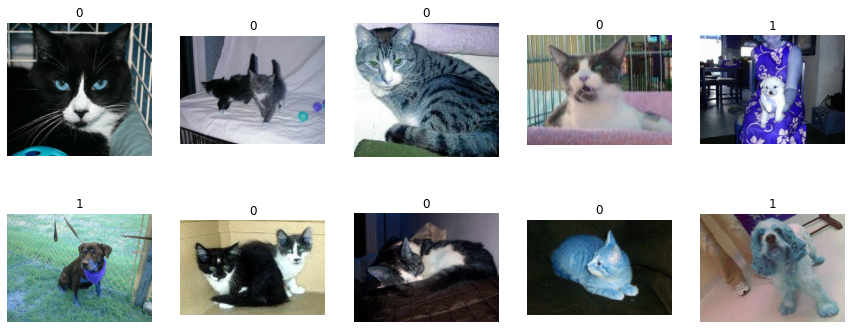

In [464]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train_tiny[i])
    ax.set_title(f"{y_train_tiny[i]}")
    ax.axis("off")